<a href="https://colab.research.google.com/github/ManishaGurugubelli/Infosys_text_analysis/blob/main/Infosys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---AUTHENTICATION METHOD ---

# Install the Kaggle package
!pip install kaggle --upgrade

# Import Colab's file uploader utility
from google.colab import files
print("Please upload your kaggle.json file in the box that appears below.")

# This command opens the upload dialog box
uploaded = files.upload()

# Set up the credentials
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Kaggle setup complete. Ready to download data.")

Please upload your kaggle.json file in the box that appears below.


Saving kaggle.json to kaggle.json
Kaggle setup complete. Ready to download data.


In [ ]:
# --- DOWNLOAD THE RAW DATA ---
!kaggle datasets download -d snap/amazon-fine-food-reviews
!unzip amazon-fine-food-reviews.zip
print("Data downloaded and extracted. Reviews.csv is ready.")

Dataset URL: https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews
License(s): CC0-1.0
amazon-fine-food-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  amazon-fine-food-reviews.zip
replace Reviews.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: Reviews.csv             
replace database.sqlite? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: database.sqlite         
replace hashes.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: hashes.txt              
Data downloaded and extracted. Reviews.csv is ready.


In [ ]:
# BALANCED DATASET CREATION

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

print("Starting Data Acquisition and Balanced Resampling...")

df_raw = pd.read_csv('Reviews.csv')

df_clean = df_raw.dropna(subset=['Text', 'Score'])
df_clean.drop_duplicates(subset=['UserId', 'ProfileName', 'Time', 'Text'], inplace=True)

min_size = df_clean[df_clean['Score'] == 2].shape[0]

print(f"Minimum class size found (Score 2): {min_size}")

df_balanced_list = []
for score in sorted(df_clean['Score'].unique()):
    df_score = df_clean[df_clean['Score'] == score]

    df_score_balanced = resample(
        df_score,
        replace=False,
        n_samples=min_size,
        random_state=42
    )
    df_balanced_list.append(df_score_balanced)

df_sample = pd.concat(df_balanced_list)

df_sample = df_sample.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nNew Balanced Dataset Shape: {df_sample.shape}")
print(df_sample['Score'].value_counts().sort_index())
print("\nBalanced dataset created successfully!")

Starting Data Acquisition and Balanced Resampling...
Minimum class size found (Score 2): 20802

New Balanced Dataset Shape: (104010, 10)
Score
1    20802
2    20802
3    20802
4    20802
5    20802
Name: count, dtype: int64

Balanced dataset created successfully!


In [ ]:
# TEXT PREPROCESSING AND CLEANING (WITH SAMPLE OUTPUT)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK components if not already done
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
try:
    WordNetLemmatizer().lemmatize('test')
except LookupError:
    nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    # Remove HTML tags (e.g., <br />)
    text = re.sub(r'<.*?>', '', text)
    # Remove punctuation, numbers, and special characters, and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    # Tokenize, remove stop words, and lemmatize
    words = text.split()
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words and len(w) > 2]
    return ' '.join(words)

print("\nStarting Text Preprocessing...")
df_sample['CleanedText'] = df_sample['Text'].apply(clean_text)
print("Preprocessing complete. 'CleanedText' column created.")

# --- SAMPLE OUTPUT ---
print("\n--- Preprocessing Sample (5 Rows) ---")
print(df_sample[['Score', 'Text', 'CleanedText']].sample(5, random_state=1).to_markdown(index=False))


Starting Text Preprocessing...
Preprocessing complete. 'CleanedText' column created.

--- Preprocessing Sample (5 Rows) ---
|   Score | Text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         | CleanedText                                                                                                                                                                                                                                                                                                                     

In [ ]:
# FEATURE EXTRACTION AND TOPIC MODELING (NMF)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

N_TOPICS = 5
print("\nStarting Feature Extraction and NMF Topic Modeling...")

# Feature Extraction (TF-IDF)
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df_sample['CleanedText'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

print(f"TF-IDF Matrix Shape: {X_tfidf.shape}")

# Topic Modeling (NMF)
nmf_model = NMF(n_components=N_TOPICS, random_state=42, max_iter=300, solver='mu')
nmf_model.fit(X_tfidf)
nmf_W = nmf_model.transform(X_tfidf)

# Function to display topics
def display_topics(model, feature_names, n_top_words=10):
    topic_keywords = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words_idx = topic.argsort()[:-n_top_words - 1:-1]
        top_words = [feature_names[i] for i in top_words_idx]
        topic_name = f"Topic {topic_idx + 1}: {' | '.join(top_words[:3])}"
        topic_keywords[topic_name] = top_words
        print(f"{topic_name}: {' | '.join(top_words)}")
    return topic_keywords

print("\n--- NMF Topics ---")
topic_keywords_dict = display_topics(nmf_model, tfidf_feature_names)
print("Topic Modeling Complete.")


Starting Feature Extraction and NMF Topic Modeling...
TF-IDF Matrix Shape: (104010, 5000)

--- NMF Topics ---
Topic 1: taste | like | flavor: taste | like | flavor | good | chocolate | really | one | dont | would | sugar
Topic 2: coffee | cup | roast: coffee | cup | roast | bean | strong | pod | flavor | blend | starbucks | drink
Topic 3: tea | green | bag: tea | green | bag | flavor | drink | cup | leaf | black | iced | taste
Topic 4: dog | food | treat: dog | food | treat | cat | love | eat | chew | one | ingredient | chicken
Topic 5: product | price | amazon: product | price | amazon | box | store | order | bag | buy | time | great
Topic Modeling Complete.


In [ ]:
# ---  CONVERT TO BINARY TARGET VARIABLE ---

# Assumes df_sample is available from previous steps.
print("Converting 5-class Scores to Binary Sentiment (Positive=1, Negative/Neutral=0)...")

# Define the function to map scores to binary sentiment
def map_sentiment(score):
    # 4 and 5 stars are Positive
    if score >= 4:
        return 1
    # 1, 2, and 3 stars are Negative/Neutral
    else:
        return 0

df_sample['Sentiment'] = df_sample['Score'].apply(map_sentiment)

# Check the new binary distribution
print("\nNew Binary Target Distribution:")
print(df_sample['Sentiment'].value_counts())

Converting 5-class Scores to Binary Sentiment (Positive=1, Negative/Neutral=0)...

New Binary Target Distribution:
Sentiment
0    62406
1    41604
Name: count, dtype: int64


In [ ]:
# ---  TRAIN AND EVALUATE BINARY CLASSIFICATION MODEL ---

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

print("\nStarting Binary Logistic Regression Model Training...")

# Use the new binary target variable
y_binary = df_sample['Sentiment']

# X_tfidf is already balanced and ready.
# We split the data using the new binary target for stratification.
# Stratify ensures the 60/40 balance is maintained in both train and test sets.
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_tfidf, y_binary, test_size=0.3, random_state=42, stratify=y_binary
)

# Train Logistic Regression Model
model_binary = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)
model_binary.fit(X_train_bin, y_train_bin)

# Predict and Evaluate
y_train_pred_bin = model_binary.predict(X_train_bin)
y_test_pred_bin = model_binary.predict(X_test_bin)

print("\n--- Final Binary Classification Evaluation ---")

# Calculate Accuracy and Error Metrics
train_accuracy_bin = accuracy_score(y_train_bin, y_train_pred_bin)
test_accuracy_bin = accuracy_score(y_test_bin, y_test_pred_bin)

print(f"Training Accuracy (Memorization): {train_accuracy_bin*100:.2f}%")
print(f"Test Accuracy (Final Performance): {test_accuracy_bin*100:.2f}%")

print("\nDetailed Binary Classification Report:")
# 0 is Negative/Neutral, 1 is Positive
print(classification_report(y_test_bin, y_test_pred_bin, target_names=['Negative/Neutral (0)', 'Positive (1)']))


Starting Binary Logistic Regression Model Training...

--- Final Binary Classification Evaluation ---
Training Accuracy (Memorization): 83.96%
Test Accuracy (Final Performance): 81.78%

Detailed Binary Classification Report:
                      precision    recall  f1-score   support

Negative/Neutral (0)       0.83      0.88      0.85     18722
        Positive (1)       0.80      0.73      0.76     12481

            accuracy                           0.82     31203
           macro avg       0.81      0.80      0.81     31203
        weighted avg       0.82      0.82      0.82     31203



In [ ]:
!pip install gensim

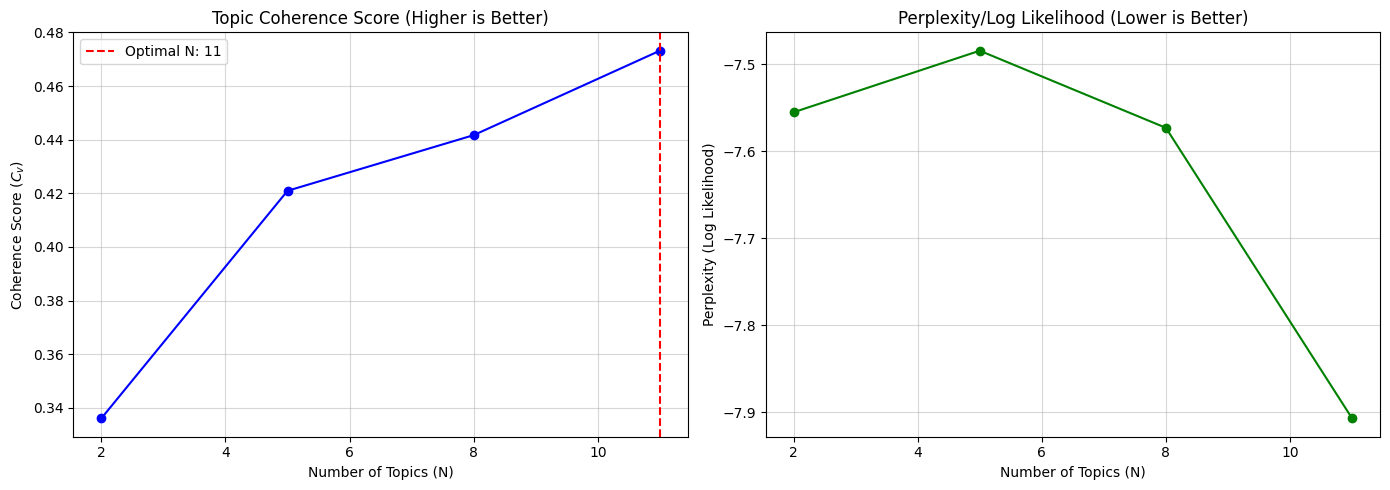


Analysis complete. Optimal N based on Coherence is N=11.
Coherence Scores: [0.3360888703679966, 0.42093553881658224, 0.4416933423922453, 0.4731767112262522]
Perplexity (Log Likelihood) Scores: [-7.555388887573104, -7.484634726852743, -7.573304522650621, -7.907285413328229]


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

# --- Data Preparation ---
tokenized_texts = [text.split() for text in df_sample['CleanedText'].tolist()]
dictionary = Dictionary(tokenized_texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

# --- Metrics Calculation Function ---
def compute_metrics(dic, corp, texts, limit, step):
    coherence = []
    perplexity = []
    for num_topics in range(2, limit, step):
        model = LdaModel(corpus=corp, id2word=dic, num_topics=num_topics, random_state=42, passes=5)
        coherence.append(CoherenceModel(model=model, texts=texts, dictionary=dic, coherence='c_v').get_coherence())
        perplexity.append(model.log_perplexity(corp))
    return coherence, perplexity

# --- Run Analysis ---
limit = 12
step = 3
coherence_scores, perplexity_scores = compute_metrics(
    dictionary, corpus, tokenized_texts, limit, step
)

x = range(2, limit, step)
optimal_topics_coherence = x[np.argmax(coherence_scores)]

# --- Plot Results (Coherence & Log Likelihood) ---
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(x, coherence_scores, marker='o', color='blue')
plt.axvline(x=optimal_topics_coherence, color='r', linestyle='--', label=f'Optimal N: {optimal_topics_coherence}')
plt.xlabel("Number of Topics (N)")
plt.ylabel("Coherence Score ($C_v$)")
plt.title("Topic Coherence Score (Higher is Better)")
plt.legend()
plt.grid(True, alpha=0.5)

plt.subplot(1, 2, 2)
plt.plot(x, perplexity_scores, marker='o', color='green')
plt.xlabel("Number of Topics (N)")
plt.ylabel("Perplexity (Log Likelihood)")
plt.title("Perplexity/Log Likelihood (Lower is Better)")
plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

print(f"\nAnalysis complete. Optimal N based on Coherence is N={optimal_topics_coherence}.")
print(f"Coherence Scores: {coherence_scores}")
print(f"Perplexity (Log Likelihood) Scores: {perplexity_scores}")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#we trained the model to be unbaised by balancing them but when the real dataset contains huge difference
#first identifying Positive reviews, and then using a second model to split the remaining reviews into Negative and Neutral.

df_sample['Predicted_Sentiment'] = model_binary.predict(X_tfidf)

df_not_positive = df_sample[df_sample['Score'] <= 3].copy()
df_not_positive['Negative_vs_Neutral'] = df_not_positive['Score'].apply(lambda score: 0 if score <= 2 else 1)
y_cascading_2 = df_not_positive['Negative_vs_Neutral']

X_tfidf_cascading_2 = X_tfidf[df_not_positive.index]

X_train_c2, X_test_c2, y_train_c2, y_test_c2 = train_test_split(
    X_tfidf_cascading_2, y_cascading_2, test_size=0.3, random_state=42, stratify=y_cascading_2
)
model_neg_vs_neut = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)
model_neg_vs_neut.fit(X_train_c2, y_train_c2)

y_pred_model_2 = model_neg_vs_neut.predict(X_tfidf_cascading_2)
df_not_positive['Predicted_Model_2'] = y_pred_model_2

df_sample['Predicted_3_Class_Cascading'] = df_sample['Predicted_Sentiment']

df_sample['Predicted_3_Class_Cascading'] = df_sample['Predicted_3_Class_Cascading'].replace({1: 2})

df_sample.loc[df_sample['Predicted_Sentiment'] == 0, 'Predicted_3_Class_Cascading'] = (
    df_not_positive.loc[df_not_positive.index, 'Predicted_Model_2']
)

def map_final_cascade(score):
    if score == 2:
        return "Positive"
    elif score == 1:
        return "Neutral"
    else:
        return "Negative"

df_sample['Sentiment_Label_3_Class'] = df_sample['Predicted_3_Class_Cascading'].apply(map_final_cascade)

print("High-Accuracy 3-Class Sentiment Detection Complete.")
print("Sentiment Distribution:")
print(df_sample['Sentiment_Label_3_Class'].value_counts().to_string())

Final High-Accuracy 3-Class Sentiment Detection Complete.
Final Sentiment Distribution:
Sentiment_Label_3_Class
Negative    55682
Positive    38332
Neutral      9996
